# Task 1 : Set up colab gpu runtime environment

In [43]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-rj3b4iin
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-rj3b4iin
  Resolved https://github.com/albumentations-team/albumentations to commit dfa92b81d855e52f98985f7c7f7307a8ab07116f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Download Dataset




In [44]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


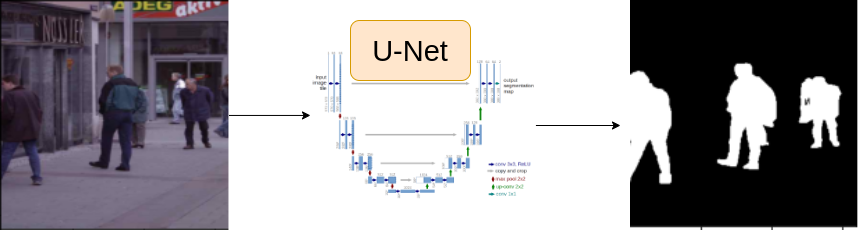

# Some Common Imports

In [45]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [46]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [47]:
CSV_FILe = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR =0.003
IMG_SIZE = 256
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [48]:
data = pd.read_csv(CSV_FILe)
data.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [49]:
row = data.iloc[10]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0

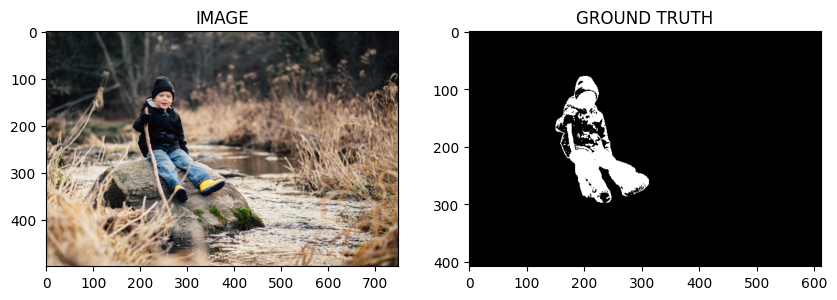

In [50]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [51]:
train_data, valid_data = train_test_split(data, test_size=0.2, random_state=42)

In [52]:
print(len(valid_data))

58


# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [53]:
import albumentations as A

In [54]:
def get_train_aug():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ])

def get_valid_aug():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE)
      ])

# Task 4 : Create Custom Dataset

In [55]:
from torch.utils.data import Dataset

In [56]:
class SegmentationDataset(Dataset):
    def __init__(self, data, augmentation):
        self.data = data
        self.augmentation = augmentation

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]

        image_path = row.images
        mask_path = row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # (h, w)
        mask = np.expand_dims(mask, axis=-1)  # (h, w, 1)

        if image.shape[:2] != mask.shape[:2]:
            mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

        if self.augmentation:
            aug_data = self.augmentation(image=image, mask=mask)
            image = aug_data['image']
            mask = aug_data['mask']

        if mask.ndim == 2:
            mask = np.expand_dims(mask, axis=-1)

        # (h, w, c) -> (c, h, w)
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)


        return image, mask

In [57]:
train_set = SegmentationDataset(train_data, get_train_aug())
valid_set = SegmentationDataset(valid_data,get_valid_aug())

In [58]:
print(f"Size of Trainset : {len(train_set)}")
print(f"Size of Validset : {len(valid_set)}")

Size of Trainset : 232
Size of Validset : 58


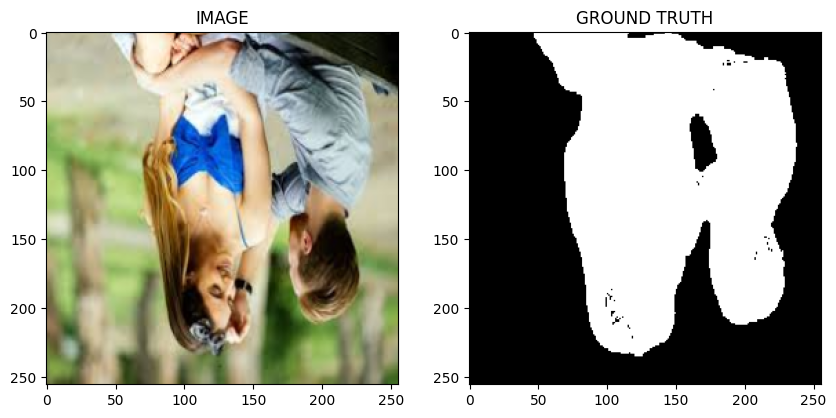

In [59]:
index = 6
image, mask =train_set[index]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [60]:
from torch.utils.data import DataLoader

In [61]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle= True)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle= True)

In [62]:
print(f"total no. of batches in train_loader:{len(train_loader)}")
print(f"total no. of batches in valid_loader:{len(valid_loader)}")


total no. of batches in train_loader:15
total no. of batches in valid_loader:4


In [63]:
for image, mask in train_loader:
  break

print(f"One batch image shape: {image.shape}")
print(f"One batch image shape: {mask.shape}")

One batch image shape: torch.Size([16, 3, 256, 256])
One batch image shape: torch.Size([16, 1, 256, 256])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [64]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [65]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.arc =smp.Unet(
        encoder_name= ENCODER,
        encoder_weights=WEIGHTS,
        in_channels= 3,
        classes = 1,
        activation= None
    )

  def forward(self,images,masks = None):

      logits = self.arc(images)

      if masks != None:
        loss1 = DiceLoss(mode='binary')(logits,masks)
        loss2 = nn.BCEWithLogitsLoss()(logits,masks)
        return logits, loss1+loss2
      return logits

In [66]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [67]:
def train_fn(data_loader,model,optimizer):

  model.train()
  total_loss = 0.0

  for images, masks  in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images,masks)
    loss.backward()
    optimizer.step()

    total_loss +=loss.item()

  return total_loss / len(data_loader)


In [68]:
def eval_fn(data_loader,model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks  in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images,masks)

      total_loss +=loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [69]:
optimizer = torch.optim.Adam(model.parameters(),lr=LR)

In [70]:
best_valid_loss = np.Inf

for i in range (EPOCHS):

  train_loss = train_fn(train_loader, model, optimizer)
  valid_loss = eval_fn(valid_loader, model)

  if valid_loss< best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print('Model Saved')
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} Train loss : {train_loss} Valid loss : {valid_loss }")

100%|██████████| 4/4 [00:00<00:00,  4.42it/s]


Model Saved
Epoch : 1 Train loss : 0.7679461022218068 Valid loss : 0.7361567318439484


100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


Model Saved
Epoch : 2 Train loss : 0.37168593406677247 Valid loss : 0.46277985721826553


100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


Model Saved
Epoch : 3 Train loss : 0.29754702051480614 Valid loss : 0.4286057874560356


100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


Model Saved
Epoch : 4 Train loss : 0.3592086871465047 Valid loss : 0.2487245835363865


100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Epoch : 5 Train loss : 0.2559995869795481 Valid loss : 0.32622678577899933


100%|██████████| 4/4 [00:00<00:00,  6.13it/s]


Model Saved
Epoch : 6 Train loss : 0.23833287457625071 Valid loss : 0.24313368275761604


100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


Model Saved
Epoch : 7 Train loss : 0.2315648486216863 Valid loss : 0.21574464812874794


100%|██████████| 4/4 [00:00<00:00,  6.07it/s]


Model Saved
Epoch : 8 Train loss : 0.2145105948050817 Valid loss : 0.20015396177768707


100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


Epoch : 9 Train loss : 0.20127589205900828 Valid loss : 0.2633196450769901


100%|██████████| 4/4 [00:00<00:00,  6.16it/s]


Epoch : 10 Train loss : 0.16437118152777355 Valid loss : 0.20374758541584015


100%|██████████| 4/4 [00:00<00:00,  6.24it/s]


Epoch : 11 Train loss : 0.18023981700340908 Valid loss : 0.2679065875709057


100%|██████████| 4/4 [00:00<00:00,  6.13it/s]


Epoch : 12 Train loss : 0.19145969649155933 Valid loss : 0.2727792114019394


100%|██████████| 4/4 [00:00<00:00,  6.17it/s]


Epoch : 13 Train loss : 0.15706349511941273 Valid loss : 0.23494140431284904


100%|██████████| 4/4 [00:00<00:00,  6.18it/s]


Epoch : 14 Train loss : 0.1434397558371226 Valid loss : 0.20476288348436356


100%|██████████| 4/4 [00:00<00:00,  6.04it/s]


Epoch : 15 Train loss : 0.14993692338466644 Valid loss : 0.2404593639075756


100%|██████████| 4/4 [00:00<00:00,  4.32it/s]


Epoch : 16 Train loss : 0.142173537115256 Valid loss : 0.2577844187617302


100%|██████████| 4/4 [00:00<00:00,  6.10it/s]


Epoch : 17 Train loss : 0.14693593382835388 Valid loss : 0.22544576227664948


100%|██████████| 4/4 [00:00<00:00,  4.40it/s]


Model Saved
Epoch : 18 Train loss : 0.1215003952383995 Valid loss : 0.17528676614165306


100%|██████████| 4/4 [00:00<00:00,  6.02it/s]


Model Saved
Epoch : 19 Train loss : 0.11428544074296951 Valid loss : 0.17472954466938972


100%|██████████| 4/4 [00:00<00:00,  6.11it/s]


Epoch : 20 Train loss : 0.1664070914189021 Valid loss : 0.22098764777183533


100%|██████████| 4/4 [00:00<00:00,  5.80it/s]


Epoch : 21 Train loss : 0.14088405221700667 Valid loss : 0.3369603417813778


100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


Epoch : 22 Train loss : 0.14909803618987402 Valid loss : 0.24161477759480476


100%|██████████| 4/4 [00:00<00:00,  6.09it/s]


Epoch : 23 Train loss : 0.12633246084054311 Valid loss : 0.19686229713261127


100%|██████████| 4/4 [00:00<00:00,  6.00it/s]


Epoch : 24 Train loss : 0.11654319018125534 Valid loss : 0.17505814880132675


100%|██████████| 4/4 [00:00<00:00,  6.09it/s]

Epoch : 25 Train loss : 0.10731419076522192 Valid loss : 0.19566291570663452


# Task 9 : Inference

In [71]:
index = 3
model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = valid_set[index]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask>0.5)*1.0

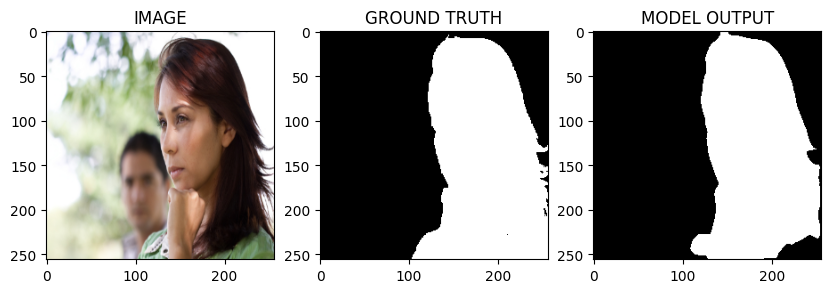

In [72]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))